In [ ]:
# Capstone Project
> Capstone Project

- toc: true
- badges: true
- comments: true
- sticky_rank: 1
- author: Felix
- categories: [ibm, data_science, ml, visualization]

# Capstone Project
## Finding a location and type for a restaurant in Los Angeles County, CA

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)


## Introduction: Business Problem <a name="introduction"></a>


In this project I will try to give a recommendation on where to open a
restaurant in Los Angeles County, CA. In addition, there shall be given  a
recommendation of which type of restaurant could be opened, based on
existing restaurants in the area and generally popular restaurants in the
whole county.

The decision on where to open a restaurant can be based on many factors,
depending on the target group. For example, one could look for very dense
populated areas, or areas with lots of wealthy citizens. Even the median age
 of the population can play a role.

I will make a decision based on the following conditions:
- Find the area with a good balance between number of possible customers
and a high median income (population is slightly more important than income)
- the type of restaurant will be determined by the most recommended categories
 of food venue in Los Angeles County, CA and the number of already existing
 venues in the area

## Data <a name="data"></a>

I used three different datasets as basis for my analysis. Using these
datasets I am able to work with the following features, among others:
- A list of areas in Los Angeles County, CA based on the ZIP code
- The number of citizens and households in every area
- The estimated median income of every area
- The latitude and longitude for every zip code in the county

<br />

I combined the following datasets for this:
-	2010 Los Angeles Census Data
    - 	https://www.kaggle.com/cityofLA/los-angeles-census-data
-	Median Household Income by Zip Code in 2019
    -	http://www.laalmanac.com/employment/em12c.php
-	US Zip Code Latitude and Longitude
    -   https://public.opendatasoft.com/explore/dataset/us-zip-code-latitude-and-longitude/information/

To analyse the existing food venues in the county, the **Foursquare API** is
 used. With this API we can provide the data to answer the following two
 questions:
- What are the most recommended types of restaurants in the county?
- What are the existing food venues categories in the area where we want to
open a restaurant in?

<br />

#### Merging the three datasets as basis of the analytics
First, let's merge all three datasets and get rid of unnecessary
information. I will continue to use a single dataframe with the combined
datasets as basis for further analysis.<br />

The census data and the geodata for the US zip codes are available as csv
files that I will read directly into a dataframe. The records for the median
 household income are available on a website, so I downloaded the data as a
 html file, which then is used to create a dataframe. As the median income
 has a dollar sign and can not be converted into a numeric value
 automatically because of its format, we have to do some data preparation.

In [1]:
import pandas as pd

# Dataset: 2010 Los Angeles Census Data
df_census = pd.read_csv("2010-census-populations-by-zip-code.csv")
# Dataset: Median Household Income by Zip Code in 2019
url = "Median Household Income By Zip Code in Los Angeles County, California.html"
dfs = pd.read_html(url)
df_income_all = dfs[0]
# drop areas where the median income is missing
df_income_na = df_income_all[df_income_all['Estimated Median Income'].notna()]
# Next step: clean the values in the median income column to retrieve
# numeric values that can be used for clustering / calculation
df_income = df_income_na.drop(df_income_na[df_income_na[
                             'Estimated Median Income'] == '---'].index)
df_income['Estimated Median Income'] = \
    df_income['Estimated Median Income'].map(lambda x: x.lstrip('$'))
df_income['Estimated Median Income'] =\
    df_income['Estimated Median Income'].str.replace(',','')
df_income["Estimated Median Income"] =\
    pd.to_numeric(df_income["Estimated Median Income"])
# Dataset: US Zip Code Latitude and Longitude
df_geodata = pd.read_csv("us-zip-code-latitude-and-longitude.csv", sep=';')
# Let's start by joining the geodata on the income dataset via the zip code
df_income_geo = df_census.join(df_income.set_index('Zip Code'), on='Zip Code')
# Now join the census data with the income dataset and the geodata
dataset_geo = df_income_geo.join(df_geodata.set_index('Zip'), on='Zip Code',
                           how='left')
# Let us only use the columns we need for the further analysis and ignore
# the rest
prepared_ds = dataset_geo[[
  "Zip Code", "City", "Community", "Estimated Median Income",
  "Longitude", "Latitude", "Total Population", "Median Age",
  "Total Males", "Total Females", "Total Households",
  "Average Household Size"]]
# last stop: let's drop records with missing data
final_ds = prepared_ds.dropna(axis=0)
final_ds.shape

(279, 12)

So the final dataframe now contains 279 areas with 12 features. <br />
Let's get an overview on how the records look now:

In [2]:
final_ds.head(5)

,Zip Code,City,Community,Estimated Median Income,Longitude,Latitude,Total Population,Median Age,Total Males,Total Females,Total Households,Average Household Size
1,90001,Los Angeles,"Los Angeles (South Los Angeles), Florence-Graham",43360.0,-118.24878,33.972914,57110,26.6,28468,28642,12971,4.40
2,90002,Los Angeles,"Los Angeles (Southeast Los Angeles, Watts)",37285.0,-118.24845,33.948315,51223,25.5,24876,26347,11731,4.36
3,90003,Los Angeles,"Los Angeles (South Los Angeles, Southeast Los ...",40598.0,-118.27600,33.962714,66266,26.3,32631,33635,15642,4.22
4,90004,Los Angeles,"Los Angeles (Hancock Park, Rampart Village, Vi...",49675.0,-118.30755,34.077110,62180,34.8,31302,30878,22547,2.73
5,90005,Los Angeles,"Los Angeles (Hancock Park, Koreatown, Wilshire...",38491.0,-118.30848,34.058911,37681,33.9,19299,18382,15044,2.50


#### Finding the most recommended food venue categories in the county <br />
Now we will use the Foursquare API to find out what are the most recommended
 food venues in the county. For this we will go through every single area
 and get the recommended food venues in the vicinity of the area center.

In [3]:
# first, lets import the necessary libraries and the credentials for the API
import foursquare
import requests
CLIENT_ID = foursquare.CLIENT_ID
CLIENT_SECRET = foursquare.CLIENT_SECRET
ACCESS_TOKEN = foursquare.ACCESS_TOKEN
VERSION = '20210514' # Foursquare API version
LIMIT = 100

In [4]:
# first, we use a list of the areas and without columns we don't need
areas = final_ds.drop(['Estimated Median Income', 'Total ' 'Population',
                        'Median Age', 'Total Males', 'Total Females',
                        'Total Households', 'Average Household Size'], 1)
areas.head()

,Zip Code,City,Community,Longitude,Latitude
1,90001,Los Angeles,"Los Angeles (South Los Angeles), Florence-Graham",-118.24878,33.972914
2,90002,Los Angeles,"Los Angeles (Southeast Los Angeles, Watts)",-118.24845,33.948315
3,90003,Los Angeles,"Los Angeles (South Los Angeles, Southeast Los ...",-118.27600,33.962714
4,90004,Los Angeles,"Los Angeles (Hancock Park, Rampart Village, Vi...",-118.30755,34.077110
5,90005,Los Angeles,"Los Angeles (Hancock Park, Koreatown, Wilshire...",-118.30848,34.058911


In the next code block, we will iterate through every area in the dataframe
and get up to 50 recommendations per area. For that I use the "explore"
endpoint of the Foursquare API. I use the *categoryId* and
*sortByPopularity* parameters to only request food venues that are sorted by
 popularity in descending order.

In [5]:
venues_list = []
for index, area in areas.iterrows():
    url = 'https://api.foursquare' \
      '.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},' \
      '{}&radius={}&limit={}&offset={}&categoryId={}&sortByPopularity={}'\
        .format(
    CLIENT_ID, CLIENT_SECRET, VERSION, area['Latitude'], area['Longitude'],
    1000, LIMIT, 0, '4d4b7105d754a06374d81259', 1)

    results = requests.get(url).json()["response"]['groups'][0]['items']
    for v in results:
        try: # try to extract the city, if there is one in the response
            city = v['venue']['location']['city']
        except:
            city = area['City']

        try: # try to extract the zip code, if there is one
            postalCode = str(v['venue']['location']['postalCode'])
        except:
            postalCode = str(area['Zip Code'])
        # build a list with all the columns I want to use
        if postalCode == str(area['Zip Code']):
            venues_list.append((
                        area['Zip Code'],
                        area['Community'],
                        area['Latitude'],
                        area['Longitude'],
                        v['venue']['name'],
                        v['venue']['categories'][0]['name'],
                        city ))
# create a dataframe from the results of the request
la_venues = pd.DataFrame(venues_list, columns=['Zip Code', 'Community',
              'Zip Code Latitude', 'Zip Code Longitude', 'Venue',
              'Venue Category', 'City'])

In [6]:
la_venues.head()

,Zip Code,Community,Zip Code Latitude,Zip Code Longitude,Venue,Venue Category,City
0,90001,"Los Angeles (South Los Angeles), Florence-Graham",33.972914,-118.24878,Mi Lindo Nayarit Mariscos,Mexican Restaurant,Los Angeles
1,90001,"Los Angeles (South Los Angeles), Florence-Graham",33.972914,-118.24878,Happy Donut,Donut Shop,Los Angeles
2,90001,"Los Angeles (South Los Angeles), Florence-Graham",33.972914,-118.24878,Jack in the Box,Fast Food Restaurant,Los Angeles
3,90001,"Los Angeles (South Los Angeles), Florence-Graham",33.972914,-118.24878,Birrieria Tlaquepaque,Mexican Restaurant,Los Angeles
4,90001,"Los Angeles (South Los Angeles), Florence-Graham",33.972914,-118.24878,Birrieria Jalisco,Mexican Restaurant,Los Angeles


In [7]:
la_venues["Venue"].count()

8635

So we have found 8,635 recommendations for our 279 areas in Los Angeles
County, CA. That are ~31 recommendations per area. Let's extract the city
and venue category and group the data by category, to find out about the
distribution of the recommended food venue categories.

In [8]:
venues = la_venues[['City', 'Venue Category']]
categories = venues.groupby('Venue Category').size().to_frame('Count').reset_index()
sorted = categories.sort_values(by='Count', ascending=False) # Sort by Count
top10 = sorted.iloc[0:9] # Show the top 10 categories
top10

,Venue Category,Count
77,Mexican Restaurant,831
89,Pizza Place,569
41,Fast Food Restaurant,503
23,Chinese Restaurant,414
9,Bakery,346
99,Sandwich Place,338
2,American Restaurant,318
18,Café,303
14,Burger Joint,259


After that, we will visualize the distribution.

In [9]:
import plotly.express as px
top15 = sorted.iloc[0:14]
fig = px.bar(top15, x="Venue Category", y="Count",
             title='Distribution of recommended food venue categories')
fig.show(renderer='notebook_connected')

So with this data we can tell what food venue categories are recommended the
 most throughout Los Angeles County, CA. <br />

We have prepared the following data, which we will use for further analysis:
- a dataframe with areas in LA County, enriched with geodata, median income
and census data
- a dataframe with the most recommended food venue categories in the county

## Methodology <a name="methodology"></a>

In this project we will focus on finding a suitable area for a new
restaurant in Los Angeles County, CA. The areas are defined by their US Zip
Code. In addition, we will look at the most
recommended food venue categories throughout the country, to suggest which
type of restaurant could be opened. There won't be a specific location in
the chosen area recommended.

In the first step we have merged three different datasets, that provide data
 on the different areas in Los Angeles County. With this data it is possible
  to cluster the areas using information like median income, number of
  households and number of inhabitants. In addition, using Foursquare, we
  identified the most recommended food venue categories in the county.

The second step in the analysis is to cluster (using k-means clustering) the
areas in the county and to describe the individual clusters. Using this
method we support the process of finding a single area that looks promising
for a new restaurant.

The third step is to pick a cluster that fits the chosen criteria most. The
area shall be chosen under the premise of finding a good balance between estimated median income and number of potential
 customers. So the target is to find an area that has as many citizens as
 possible with the highest income possible. After an area was chosen, the
 distribution of local restaurant types in this area will be analysed.
 Combining this information with the categories of food venues that are
 popular throughout the county, a recommendation of the restaurant to open
 can be given.

## Analysis <a name="analysis"></a>

#### Getting an overview
First of all, let's have a look on our dataset describing the areas.

In [10]:
final_ds.head()

,Zip Code,City,Community,Estimated Median Income,Longitude,Latitude,Total Population,Median Age,Total Males,Total Females,Total Households,Average Household Size
1,90001,Los Angeles,"Los Angeles (South Los Angeles), Florence-Graham",43360.0,-118.24878,33.972914,57110,26.6,28468,28642,12971,4.40
2,90002,Los Angeles,"Los Angeles (Southeast Los Angeles, Watts)",37285.0,-118.24845,33.948315,51223,25.5,24876,26347,11731,4.36
3,90003,Los Angeles,"Los Angeles (South Los Angeles, Southeast Los ...",40598.0,-118.27600,33.962714,66266,26.3,32631,33635,15642,4.22
4,90004,Los Angeles,"Los Angeles (Hancock Park, Rampart Village, Vi...",49675.0,-118.30755,34.077110,62180,34.8,31302,30878,22547,2.73
5,90005,Los Angeles,"Los Angeles (Hancock Park, Koreatown, Wilshire...",38491.0,-118.30848,34.058911,37681,33.9,19299,18382,15044,2.50


Now we are going to take a look at the areas with the highest income and the
 highest population.

In [11]:
# sort descending by the income and draw the top 15 areas
income_sorted = final_ds.sort_values(by='Estimated Median Income',
                                     ascending=False)
income_top15 = income_sorted.iloc[0:14]
fig = px.bar(income_top15, x="Estimated Median Income", y="City",
 orientation = "h", color='Estimated Median Income',
             title='Distribution of Estimated Median Income')
fig.show(renderer='notebook_connected')

In [12]:
# sort descending by the population and draw the top 15 areas
pop_sorted = final_ds.sort_values(by='Total Population',
                                     ascending=False)
pop_top15 = pop_sorted.iloc[0:14]
fig = px.bar(pop_top15, y="Total Population", x="City",
 orientation = "v", color='Total Population',
             title='Distribution of Population')
fig.show(renderer='notebook_connected')

As we are primarily interested in the areas that have a high total
population, let us add the income to this graph and get an overview on which
areas in this group have the highest income.

In [13]:
fig = px.scatter(pop_top15, x="Estimated Median Income", y="Community",
                 size="Total Population", log_x=True, color="Total Population")
fig.show(renderer='notebook_connected')

In this graph the population determines the bubble size. So there are four
areas that stand out:

| City    | Population | Median Income |
|---------|------------|--------|
| Norwalk | 105,6K     | 70,7K       |
| Lake View Terrace, Sylmar   |  91,7K          |  74K      |
| La Puente, Valinda        |  85K          |   71,2K     |
| Hansen Hills, Pacoima |  104K          |  64K      |

These four cities / neighbourhoods seem to be suitable areas, based on
their combination of population and median income. We are going to see, if
this assumption is confirmed going forward.

#### Clustering the dataset


In [14]:
from sklearn.cluster import KMeans
grouped_clustering = final_ds.drop(['Zip Code', 'City', 'Community', 'Longitude', 'Latitude', 'Total Males',
                                    'Total Females'], 1)
grouped_clustering.head()

,Estimated Median Income,Total Population,Median Age,Total Households,Average Household Size
1,43360.0,57110,26.6,12971,4.40
2,37285.0,51223,25.5,11731,4.36
3,40598.0,66266,26.3,15642,4.22
4,49675.0,62180,34.8,22547,2.73
5,38491.0,37681,33.9,15044,2.50


In [15]:
sum_of_squared_distances = []
K = range(1,15)
for k in K:
    kmeans = KMeans(n_clusters=k, init="k-means++",
                random_state=0).fit(grouped_clustering)
    sum_of_squared_distances.append(kmeans.inertia_)

#kmeans.labels_

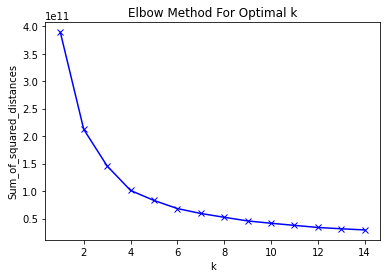

In [16]:
import matplotlib.pyplot as plt
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

According to the elbow method I chose a k of 6 going forward.
So let's do the clustering again with the determined k value.
Then I will add the cluster labels to my dataset and print out a
summarization of the created clusters.

In [19]:
# cluster with the determined K
kmeans = KMeans(n_clusters=6, init="k-means++",
                random_state=0).fit(grouped_clustering)
# add the labels to the dataset
final_ds.insert(0, 'Cluster Label', kmeans.labels_)

In [20]:
# create a dataframe for the defined clusters
cluster_df = final_ds.groupby('Cluster Label').mean()
cluster_df

,Zip Code,Estimated Median Income,Longitude,Latitude,Total Population,Median Age,Total Males,Total Females,Total Households,Average Household Size
Cluster Label,,,,,,,,,,
0,90988.629630,106149.203704,-118.326722,34.101526,29781.925926,41.064815,14563.444444,15218.481481,11475.425926,2.544815
1,90949.500000,51305.386364,-118.201435,34.097584,18681.204545,35.754545,9459.613636,9221.590909,6144.704545,2.858409
2,90624.000000,155063.444444,-118.425995,34.024770,17967.666667,43.838889,8777.833333,9189.833333,7020.722222,2.479444
3,91153.090909,57912.863636,-118.190515,34.113848,83146.500000,30.468182,41257.500000,41889.000000,22069.545455,3.768182
4,90657.634921,53158.555556,-118.258781,34.038015,49959.714286,32.455556,24713.476190,25246.238095,15571.158730,3.256984
5,91012.205128,79295.179487,-118.214638,34.056455,28459.230769,38.342308,13819.230769,14640.000000,10393.205128,2.747949


Let us clean this up a bit and add a new column, that will help us to chose
a cluster going forward.


In [21]:
clusters = cluster_df[['Estimated Median Income', 'Total Population',
                       'Median Age', 'Total Households', 'Average Household '
                                                         'Size']]

clusters['Decision Factor'] = \
    ( ( clusters['Total Population'] * 1.2 ) *
      clusters['Estimated Median Income']) / 100000
clusters_r = clusters.round(2)
clusters_r
clusters_sorted = clusters_r.sort_values(by='Decision Factor', ascending=False)
clusters_sorted

<ipython-input-21-b7541a95aecd>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Estimated Median Income,Total Population,Median Age,Total Households,Average Household Size,Decision Factor
Cluster Label,,,,,,
3,57912.86,83146.50,30.47,22069.55,3.77,57783.02
0,106149.20,29781.93,41.06,11475.43,2.54,37935.93
2,155063.44,17967.67,43.84,7020.72,2.48,33433.54
4,53158.56,49959.71,32.46,15571.16,3.26,31869.43
5,79295.18,28459.23,38.34,10393.21,2.75,27080.16
1,51305.39,18681.20,35.75,6144.70,2.86,11501.36


Looking at these clusters, they can be described as the following:

| Name      | Income | Population | Age |
|-----------|--------|------------|-----|
| Cluster 0 | High      | Medium   | Older    |
| Cluster 1 | Low       | Low      | Young    |
| Cluster 2 | Very High | Low      | Older    |
| Cluster 3 | Medium    | Very High| Very Young    |
| Cluster 4 | Low       | High     | Very Young    |
| Cluster 5 | High      | Medium   | Young    |

So based on this information I am going to choose Cluster 3 for further
evaluation and as the cluster where I will pick an area from. This cluster
has a medium income combined with a very high population. It also contains
the youngest median age, which also can be considered for choosing the
food venue category.

In [22]:
cluster3 = final_ds.loc[final_ds['Cluster Label'] == 3, final_ds
    .columns[[1] + list(range(2, final_ds.shape[1]))]]
cluster3.shape

(22, 12)

This cluster contains 22 areas in Los Angeles County, CA.
We are going to have a look on them on the map using **Folium**.

In [23]:
from geopy.geocoders import Nominatim
# initialize the map
address = 'Los Angeles County, CA'
geolocator = Nominatim(user_agent="la_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude


In [24]:
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium
import numpy as np
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)
cluster3 = final_ds.loc[final_ds['Cluster Label'] == 3]
# set color scheme for the clusters, 6 is our number of clusters
x = np.arange(6)
ys = [i + x + (i*x)**2 for i in range(6)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(cluster3['Latitude'],
                                  cluster3['Longitude'],
                                  cluster3['Zip Code'],
                                  cluster3['Cluster Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

map_clusters

As one can see, most of our areas in more densely populated areas and in the
 vicinity of the city of Los Angeles.
Now let us add the "decision factor" again and calculate it for every single
 region in cluster 3.

In [25]:
cluster3['Decision Factor'] = ( ( cluster3['Total Population'] * 1.2 ) *
                                  cluster3['Estimated Median Income']) / 100000
cluster3_r = cluster3.round(2)
cluster3_sorted = cluster3_r.sort_values(by='Decision Factor', ascending=False)
cluster3_sorted.head(10)

<ipython-input-25-12c6a3c89ae9>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Cluster Label,Zip Code,City,Community,Estimated Median Income,Longitude,Latitude,Total Population,Median Age,Total Males,Total Females,Total Households,Average Household Size,Decision Factor
132,3,90650,Norwalk,Norwalk,70667.0,-118.08,33.91,105549,32.5,52364,53185,27130,3.83,89505.97
214,3,91342,Sylmar,"Los Angeles (Lake View Terrace, Sylmar), Kagel...",74050.0,-118.43,34.31,91725,31.9,45786,45939,23543,3.83,81506.84
211,3,91331,Pacoima,"Los Angeles (Arleta, Hansen Hills, Pacoima)",63807.0,-118.42,34.25,103689,29.5,52358,51331,22465,4.60,79393.01
266,3,91744,La Puente,"City of Industry, La Puente, Valinda",71243.0,-117.94,34.03,85040,30.9,42564,42476,18648,4.55,72702.06
309,3,93536,Lancaster,"Del Sur, Fairmont, Lancaster, Metler Valley, N...",79990.0,-118.33,34.73,70918,34.4,37804,33114,20964,3.07,68072.77
129,3,90631,La Habra,La Habra Heights,83629.0,-117.95,33.93,67619,34.8,33320,34299,21452,3.13,67858.91
85,3,90250,Hawthorne,Hawthorne (Holly Park),56304.0,-118.35,33.91,93193,31.9,45113,48080,31087,2.98,62965.66
254,3,91706,Baldwin Park,"Baldwin Park, Irwindale",65755.0,-117.97,34.09,76571,30.5,37969,38602,17504,4.35,60419.11
99,3,90280,South Gate,South Gate,52321.0,-118.19,33.94,94396,29.4,46321,48075,23278,4.05,59266.72
158,3,90805,Long Beach,Long Beach (North Long Beach),50914.0,-118.18,33.87,93524,29.0,45229,48295,26056,3.56,57140.17


In [26]:
# draw the top 5 areas according to income and population
cluster3_top5 = cluster3_sorted.iloc[0:5]
fig = px.bar(cluster3_top5, x='Decision Factor', y='Community',
             color='Average Household Size' )
fig.show(renderer='notebook_connected')

So there are three areas that stand out:
- Norwalk, with a population of 105,6k and an income of $70,6k; it has the
oldest median age of the three communities and the largest population.
- Lake View Terrace in Sylmar, with a population of 91,7k and an income of
$74k; it has the highest income of the group and the lowest population.
- Hansen Hills in Pacoima, with a population 104,7k and an income of $63,8k.
 It has the youngest median age of the three and is very close to Norwalk in
  terms of population, but it has the lowest income.

Looking back at the initial analysis we did for all areas in Los Angeles
County, we find that these three areas were also part auf the group we
found, based on their features. So through the clustering we could confirm our
initial findings.

#### Exploring local food venues

Using Foursquare, we are going to query the existing food venues in the
three areas.

We will use a radius of 4 kilometres around the center of every community.
I will also use the city and zip code from the response to filter out
results from Foursquare that actually do not belong to the city community we
 are exploring.

In [27]:
import itertools
top3 = cluster3_sorted.iloc[0:3]
venues_list=[]
# Get the local food venues for all 3 of our communities
for _, record in top3.iterrows():
    offset = 0
    for _ in itertools.repeat(None, 4):
        url = 'https://api.foursquare' \
              '.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},' \
              '{}&radius={}&limit={}&offset={}&categoryId={}'.format(
            CLIENT_ID, CLIENT_SECRET, VERSION, record['Latitude'],
            record['Longitude'], 4000, 50, offset, '4d4b7105d754a06374d81259')
        # increase the offset for the next run
        offset += 50
        # try to read the items from the Foursquare response and loop over them
        try:
            results = requests.get(url).json()["response"]['groups'][0]['items']
            for v in results:
                # get the city name from the Foursquare response, if possible
                try:
                    city = v['venue']['location']['city']
                except:
                    city = str(record['City'])
                # get the zip code from the Foursquare response, if possible
                try:
                    postalCode = str(v['venue']['location']['postalCode'])
                except:
                    postalCode = str(record['Zip Code'])

                venues_list.append((record['Zip Code'], record['Community'],
                                    record['Latitude'], record['Longitude'],
                                    v['venue']['name'],
                                    v['venue']['categories'][0]['name'],
                                    city, postalCode))
        except:
            # there are no more results that Foursquare can deliver
            break
# create a dataframe from all venues we have found for all 3 areas
nearby_venues = pd.DataFrame(venues_list, columns=['Zip Code', 'Community',
              'Zip Code Latitude', 'Zip Code Longitude', 'Venue',
              'Venue Category', 'City', 'PostalCode'])
nearby_venues.count()

Zip Code              367
Community             367
Zip Code Latitude     367
Zip Code Longitude    367
Venue                 367
Venue Category        367
City                  367
PostalCode            367
dtype: int64

In [28]:
# only keep the records that belong to our 3 chosen cities
venues_cleaned = nearby_venues.loc[
                 nearby_venues['City'].isin(['Norwalk', 'Sylmar', 'Pacoima'])]
venues_cleaned.count()

Zip Code              164
Community             164
Zip Code Latitude     164
Zip Code Longitude    164
Venue                 164
Venue Category        164
City                  164
PostalCode            164
dtype: int64

We found 167 food venues across all 3 areas.
In the next step we will group the food venues by category and city.
We can use the count of food venues per category to visualize the
distribution across the communities.

In [29]:
# extract city name and food venue category
categs = venues_cleaned[['City', 'Venue Category']]
# count the number of restaurants per city and category
categs_count = categs.groupby(['City', 'Venue Category']).size().to_frame(
               'Count').reset_index()
# sort the result by city and count
categs_sorted = categs_count.sort_values(by=['City', 'Count'],
                                         ascending=False)
categs_sorted

,City,Venue Category,Count
49,Sylmar,Mexican Restaurant,13
50,Sylmar,Pizza Place,7
52,Sylmar,Sandwich Place,6
43,Sylmar,Chinese Restaurant,4
38,Sylmar,American Restaurant,3
45,Sylmar,Fast Food Restaurant,3
47,Sylmar,Fried Chicken Joint,3
44,Sylmar,Donut Shop,2
46,Sylmar,Food,2
48,Sylmar,Italian Restaurant,2


In [30]:
categs_graph = categs_sorted.loc[categs_sorted['Count'] > 1]

fig = px.bar(categs_graph, y="Venue Category",
             x="Count", title='Combined Distribution of Food Venues',
             orientation='h', color = 'City'
             )
fig.show(renderer='notebook_connected')

Having a look at the distribution of food venues across the three areas, we
can make the following observations:
- Mexican restaurants are the most common food venue overall
- Fast Food restaurants are the second most common venue, but Norwalk has by
 far the most
- Pacoima has the least restaurants overall and Norwalk the most, despite
both of them are very close in population
- There seems to be space for a Chinese or American Restaurant or a Donut
Shop in Pacoima
- Even sandwich and pizza places are not very common in Pacoima
- Opening another fast food restaurant or mexican restaurant does not seem
like a good idea

<br />
Again, let us have a look on the most recommended food venues in the county
for comparison:

In [31]:
top15 = sorted.iloc[0:14]
fig = px.bar(top15, x="Venue Category", y="Count",
             title='Distribution of recommended food venue categories')
fig.show(renderer='notebook_connected')

#### Choosing a restaurant to open
- Bakeries are the fith most recommended venue category, but there is
currently a maximum of 1 per area. So this could be a good option in any of
the three communities.
- Mexican and fast food restaurants are already very common and should not
be chosen
- There is an opportunity for a pizza place or a chinese resaturant in Pacoima
- Pacoima in general has few food venues. Looking at the median income, any
low price food venues could be a good opportunity.
- Norwalk would be the best option according to population and income, but
it is already very crowded with restaurants. A bakery seems to be the best
option there.

There are also multiple options for sushi restaurants, burger joints,
japanese or thai restaurants in all three areas. Overall not looking bad!

## Results and Discussion <a name="results"></a>


Our analysis shows that there is a high variability in population, income
and median age in the different areas of Los Angeles County, CA. So it was
possible to identify multiple areas that fit the criteria of a relatively high
median income and a high population. Using census and income data of all
areas in Los Angeles County, we did a clustering to identify similar areas.
By analysing the formed clusters there have been three areas identified
that fit the criteria best. Norwalk, Lake View Terrace in Sylmar and Hansen
Hills in Pacoima.

They are slightly different in income, population and age and also very
  different in their local distribution of available food venues. The final
  area could be picked on which of these factors matters to the stakeholders
   most. I will pick Norwalk as the final area for a food venue, because it
    offers the best combination of a high population and a good income out
    of these three areas.

By analysing the most recommended food venue categories across the whole
county, we found that mexican restaurants are by far the most often
recommended venue. After them pizza places, fast food restaurants,
chinese restaurants and bakeries follow in that order. To give a
recommendation for a food venue to open in Norwalk, we can compare the local
 distribution of food venues what was recommended the most in the county. By
  looking at Norwalk we found that there are already many mexican
  restaurants (12) and fast food restaurants (15). Pizza places (7) and
  chinese restaurants (5) area also recommended in a higher number, so
  opening a restaurant in one of those categories would be better, but there
   is still some competition. What stands out is that there is currently
   only one bakery recommended by Foursquare in Norwalk. Looking at the
   distribution of recommendations in the county, bakeries are the fifth
   most recommended venue category. Because of this, I would recommend
   opening a bakery in Norwalk, CA to the stakeholders.

Purpose of this analysis was to identify a possible area and food venue type
 for a new restaurant in Los Angeles County, CA based on a very limited
 amount of factors. Analysing census data and existing food venues is only
 one part on the way to find a location for opening a new restaurant. Other
  factors that also play a role are for example available spaces, rent
  costs, other venues in the area. This analysis serves as a starting point
  for finding possible locations, but further analysis needs to be done by
  the stakeholders.

## Conclusion <a name="conclusion"></a>

The purpose of this project was to find a possible location for a new
restaurant in Los Angeles County, CA. The desire from the stakeholders was
to identify locations that offer a good balance between median income and
number of inhabitants, although income shall be rated slightly more important
than population. In addition, the idea was to identify possible food
venue categories by comparing recommended venues across the country with the
 local venues in the different areas. So for this there were census and
 income data combined to identify areas that fit the criteria. A clustering
 was performed, to group the communities in Los Angeles County using their
 income and population. Then the cluster was chosen that fit the former
 mentioned criteria the most. From this cluster the top 3 areas were chosen,
  that had the best balance between income and population. This way the best
   three candidates for a new restaurant location were identified.

The next step was to analyze the local food venue categories. For this the
local venues in a 4 km radius were identified and grouped. This grouping was
 then compared with the distribution of the most recommended food venue
 categories across the whole county. In doing so, opportunities for new
 restaurants in any of the three chosen communities have been identified.

The final decision can be made by the stakeholders, based on the
recommendations given in this project. This decision for a locality can be
based on income, population or median age of the areas. The decision for a
venue category can be based on popular venues across the county, and the gaps
 in the local food offerings that have been identified.